In [1]:
import networkx as nx
import math

from cdlib import viz, algorithms
from cdlib.classes import NodeClustering

from stock_graph_creation import get_sp500_stocks
from stock_graph_creation import correlation_to_graph, correlation_to_pos_neg_graphs

Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'bayanpy', 'graph_tool', 'infomap'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'infomap'}


In [2]:
def info(G, fast = False):
  print("{:>12s} | '{:s}'".format('Graph', G.name))

  n = G.number_of_nodes()
  m = G.number_of_edges()
  
  print("{:>12s} | {:,d} ({:,d})".format('Nodes', n, nx.number_of_isolates(G)))
  print("{:>12s} | {:,d} ({:,d})".format('Edges', m, nx.number_of_selfloops(G)))
  print("{:>12s} | {:.2f} ({:,d})".format('Degree', 2 * m / n, max([k for _, k in G.degree()])))

  if not fast:
    C = sorted(nx.connected_components(nx.MultiGraph(G)), key = len, reverse = True)

    print("{:>12s} | {:.1f}% ({:,d})".format('LCC', 100 * len(C[0]) / n, len(C)))

    print("{:>12s} | {:.4f}".format('Clustering', nx.average_clustering(G if type(G) == nx.Graph else nx.Graph(G))))
    
    C = algorithms.leiden(G)
    Q = C.newman_girvan_modularity().score
      
    print("{:>12s} | {:.4f} ({:,d})".format('Modularity', Q, len(C.communities)))
  print()



In [3]:
correlations = get_sp500_stocks(start_date="2025-02-01", end_date="2025-03-01").corr()
G_pos, G_neg = correlation_to_pos_neg_graphs(correlations, threshold=0.7)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-02-01 -> 2025-03-01)')
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')


## Visualization

In [10]:
import matplotlib.pyplot as plt

def info(G, fast = False):
  print("{:>12s} | '{:s}'".format('Graph', G.name))

  n = G.number_of_nodes()
  m = G.number_of_edges()
  
  print("{:>12s} | {:,d} ({:,d})".format('Nodes', n, nx.number_of_isolates(G)))
  print("{:>12s} | {:,d} ({:,d})".format('Edges', m, nx.number_of_selfloops(G)))
  print("{:>12s} | {:.2f} ({:,d})".format('Degree', 2 * m / n, max([k for _, k in G.degree()])))

  if not fast:
    C = sorted(nx.connected_components(nx.MultiGraph(G)), key = len, reverse = True)

    print("{:>12s} | {:.1f}% ({:,d})".format('LCC', 100 * len(C[0]) / n, len(C)))

    print("{:>12s} | {:.4f}".format('Clustering', nx.average_clustering(G if type(G) == nx.Graph else nx.Graph(G))))
    
    C = algorithms.leiden(G)
    Q = C.newman_girvan_modularity().score
      
    print("{:>12s} | {:.4f} ({:,d})".format('Modularity', Q, len(C.communities)))
  print()

def plot_wiring_diagram(G, layout = None, C = None, S = None, label = "wiring", save_file = True):
  if layout is None:
    layout = nx.spring_layout(G)
    
  colors = None
  if C is not None:
    colors = [0] * len(G)
    for c, comm in enumerate(C.communities):
      for i in comm:
        colors[i] = c
    
  sizes = None
  if S is not None:
    sizes = [100 * len(G)] * len(G)
    for i in G.nodes():
      sizes[i] *= S[i]
  
  labels = {i: "" if G.nodes[i]['label'].isdigit() else G.nodes[i]['label'] for i in G.nodes()}
  
  plt.figure()

  nx.draw(G, pos = layout, node_color = colors, node_size = sizes, labels = labels, font_size = 5, edge_color = 'gray')
  
  if save_file:
    plt.savefig(G.name + "." + label + ".pdf", bbox_inches = 'tight')
  else:
    plt.show()
  plt.close()

def plot_block_model(G, C, save_file=False):
  plt.figure(figsize=(10, 10))
  
  C = sorted(C.communities, key = len)
  nodes = [i for c in C for i in c]
  A = nx.adjacency_matrix(G, nodelist = nodes).todense()
  
  plt.imshow(A, cmap = 'binary', interpolation = 'nearest')
  
  xy = 0
  for c in C[:-1]:
    xy += len(c)
    
    plt.plot([xy - 0.5, xy - 0.5], [-0.5, len(G) - 0.5], '-g')
    plt.plot([-0.5, len(G) - 0.5], [xy - 0.5, xy - 0.5], '-g')

  plt.yticks(range(len(G)), labels = [G.nodes[i]['label'] for i in nodes], size = 2)
  plt.xticks([])
  
  if save_file:
    plt.savefig(G.name + ".blocks.pdf", bbox_inches = 'tight')
  else:
    plt.show()
  plt.close()

In [5]:
info(G_neg)

       Graph | 'neg_correlations'
       Nodes | 503 (39)
       Edges | 11,236 (0)
      Degree | 44.68 (121)
         LCC | 91.3% (42)
  Clustering | 0.0000
  Modularity | 0.2355 (45)



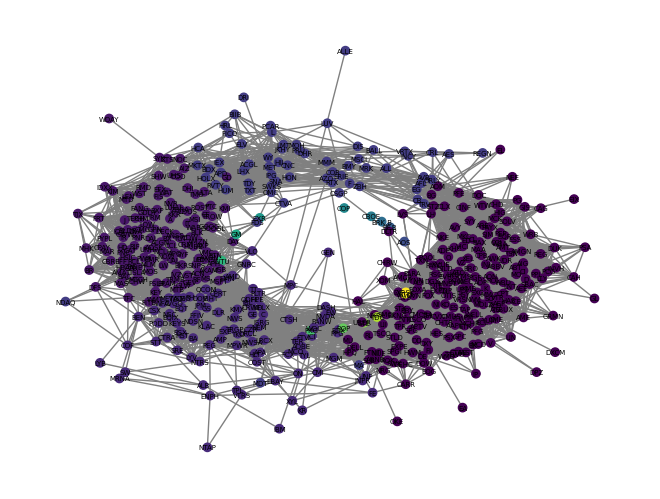

In [6]:
plot_wiring_diagram(G_pos, nx.kamada_kawai_layout(G_pos), algorithms.leiden(G_pos), save_file=False)

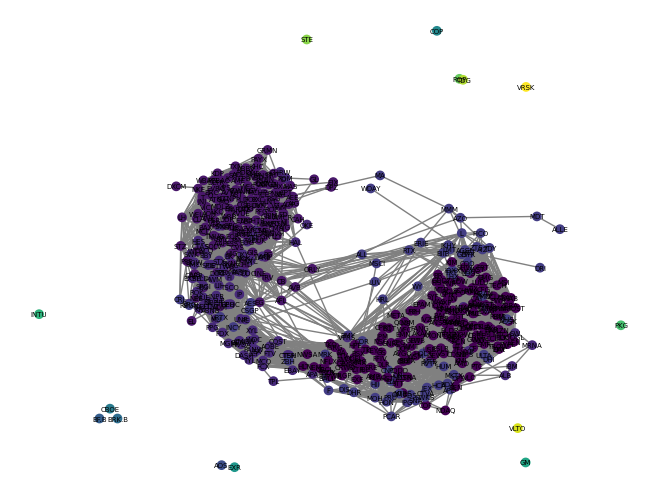

In [7]:
plot_wiring_diagram(G_pos, nx.forceatlas2_layout(G_pos), algorithms.leiden(G_pos), save_file=False)

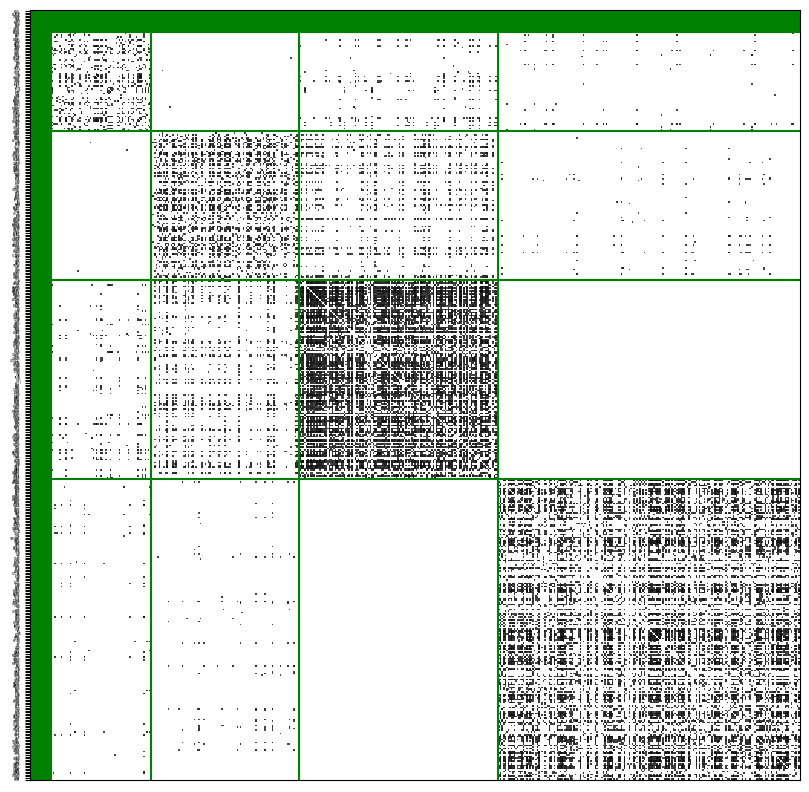

In [11]:
plot_block_model(G_pos, algorithms.leiden(G_pos), save_file=False)

## Community detection

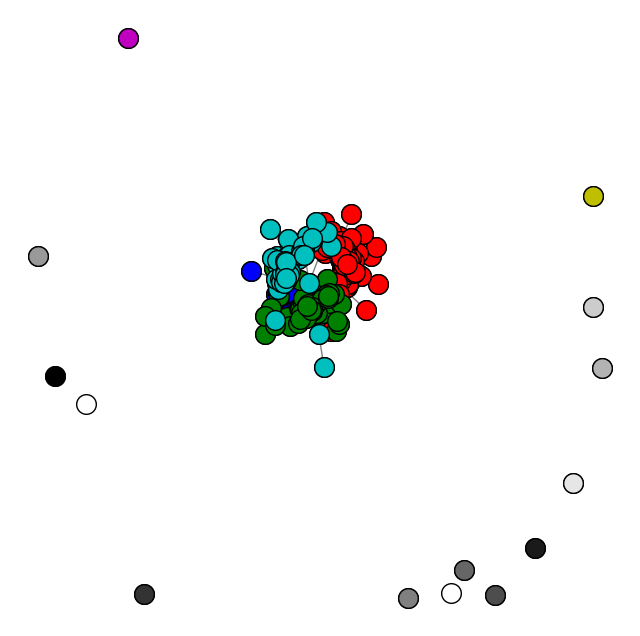

In [12]:
algs = {
    "Graph": lambda G: NodeClustering([range(len(G))],G, 'Graph'),
    "Isolates": lambda G: NodeClustering([[i] for i in range(len(G))], G, 'Isolates'),
    "MCL": algorithms.markov_clustering,
    "EMMM": lambda G: algorithms.em(G, k = 4), #expectation maximization
    "KL": lambda G: NodeClustering([list(c) for c in nx.community.kernighan_lin_bisection(G)], G, "Fast LP"),
    "Louvain": lambda G: algorithms.louvain(G),
    "Leiden": lambda G: algorithms.leiden(G),
    "Infomap": lambda G: algorithms.infomap(G),
    "LP": lambda G: algorithms.label_propagation(G),
    "FLP": lambda G: NodeClustering([list(c) for c in nx.community.fast_label_propagation_communities(G)], G, "Fast LP")
}

    
viz.plot_network_clusters(G_pos, algs["Louvain"](G_pos), nx.spring_layout(G_pos))